[View in Colaboratory](https://colab.research.google.com/github/hatu87/tensorflow-sample/blob/master/tf_eager_iris.ipynb)

In [0]:
!pip install -q --upgrade tensorflow

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
import os

In [20]:
tf.enable_eager_execution()

ValueError: ignored

In [4]:
print('tensorflow version: {}'.format(tf.__version__))
print('eager execution state: {}'.format(tf.executing_eagerly()))

tensorflow version: 1.8.0
eager execution state: True


In [13]:
train_dataset_url = 'http://download.tensorflow.org/data/iris_training.csv'
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)
print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /content/.keras/datasets/iris_training.csv


In [22]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [23]:
default = [0., 0., 0., 0., 0]
parsed_line = tf.decode_csv('6.4,2.8,5.6,2.2,2', default)
print(parsed_line)
print(parsed_line[:-1])
print(tf.reshape(parsed_line[:-1], shape=(4,)))
print(parsed_line[-1])
print(tf.reshape(parsed_line[-1], shape=()))

[<tf.Tensor: id=6, shape=(), dtype=float32, numpy=6.4>, <tf.Tensor: id=7, shape=(), dtype=float32, numpy=2.8>, <tf.Tensor: id=8, shape=(), dtype=float32, numpy=5.6>, <tf.Tensor: id=9, shape=(), dtype=float32, numpy=2.2>, <tf.Tensor: id=10, shape=(), dtype=int32, numpy=2>]
[<tf.Tensor: id=6, shape=(), dtype=float32, numpy=6.4>, <tf.Tensor: id=7, shape=(), dtype=float32, numpy=2.8>, <tf.Tensor: id=8, shape=(), dtype=float32, numpy=5.6>, <tf.Tensor: id=9, shape=(), dtype=float32, numpy=2.2>]
tf.Tensor([6.4 2.8 5.6 2.2], shape=(4,), dtype=float32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


In [0]:
def parse_csv(line):
  default = [[0.], [0.], [0.], [0.], [0]]
  parsed_line = tf.decode_csv(line, default)
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  label = tf.reshape(parsed_line[-1], shape=())
  
  return features, label

In [25]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)
train_dataset = train_dataset.map(parse_csv)
train_dataset = train_dataset.batch(10)
features, label = iter(train_dataset).next()
print('example features: {}'.format(features[0]))
print('example label: {}'.format(label[0]))

example features: [6.4 2.8 5.6 2.2]
example label: 2


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3),
])

In [0]:
def loss(model, x, y):
  y_ = model(x)
  
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
    
  return tape.gradient(loss_value, model.variables)

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [29]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  for x, y in train_dataset:
    grads = grad(model, x, y)
    
    optimizer.apply_gradients(zip(grads, model.variables),
                             global_step=tf.train.get_or_create_global_step())
    
     # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 10 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.279, Accuracy: 32.500%
Epoch 010: Loss: 0.938, Accuracy: 44.167%
Epoch 020: Loss: 0.736, Accuracy: 70.000%
Epoch 030: Loss: 0.627, Accuracy: 70.000%
Epoch 040: Loss: 0.540, Accuracy: 75.000%
Epoch 050: Loss: 0.458, Accuracy: 81.667%
Epoch 060: Loss: 0.394, Accuracy: 84.167%
Epoch 070: Loss: 0.343, Accuracy: 85.833%
Epoch 080: Loss: 0.295, Accuracy: 90.833%
Epoch 090: Loss: 0.248, Accuracy: 93.333%
Epoch 100: Loss: 0.205, Accuracy: 95.000%
Epoch 110: Loss: 0.169, Accuracy: 95.833%
Epoch 120: Loss: 0.140, Accuracy: 98.333%
Epoch 130: Loss: 0.119, Accuracy: 98.333%
Epoch 140: Loss: 0.103, Accuracy: 99.167%
Epoch 150: Loss: 0.091, Accuracy: 100.000%
Epoch 160: Loss: 0.081, Accuracy: 100.000%
Epoch 170: Loss: 0.074, Accuracy: 100.000%
Epoch 180: Loss: 0.069, Accuracy: 100.000%
Epoch 190: Loss: 0.064, Accuracy: 100.000%
Epoch 200: Loss: 0.060, Accuracy: 100.000%


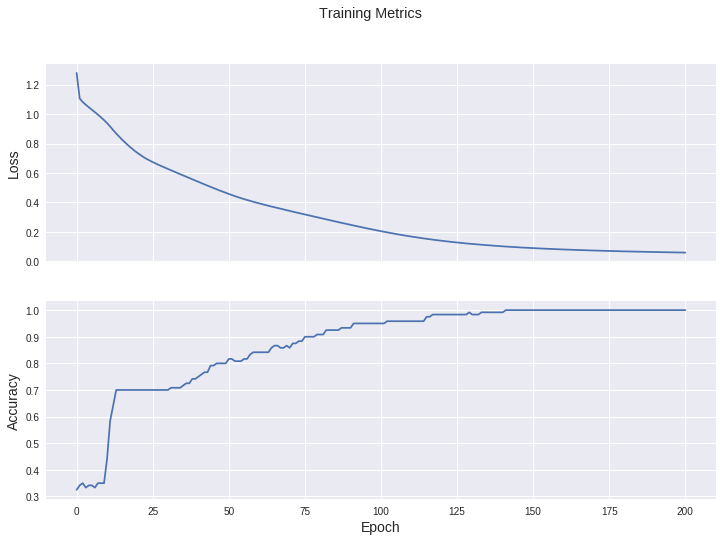

In [30]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [31]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [32]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 100.000%


In [33]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica
